# Galileo SSI

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import linregress

from ssi import SSI

In [2]:
img = SSI('C0360063913R_cal.pho.cub')
img

<SSI> Cube: C0360063913R_cal
 - Size: (800, 800)
 - Start time: 1996-09-07 14:43:14.690000
 - Filter name: VIOLET
 - Exposure: 0.2625 seconds
 - Main target: EUROPA
 - Data alignment: False

## Get a single pixel

Pixels are defined between `1` and `NS`, and, `1` and `NL`:

In [3]:
img[400, 300]  # [Sample, Line]

<SSIPixel> C0360063913R_cal-S400_L300
 - Sample: 400
 - Line: 300
 - I/F: 4.37e-01
 - Lon: 303.2°W
 - Lat: 8.0°N
 - Inc: 13.7°
 - Emi: 12.3°
 - Phase: 2.1°
 - Res: 2.1 km/pix

## Image planes

All the planes layers are:

In [4]:
img.layers

['VIOLET',
 'Phase Angle',
 'Emission Angle',
 'Incidence Angle',
 'Latitude',
 'Longitude']

All the images planes are accessibles with the following convension:

```python
VIOLET|CLEAR|… => data
Latitude => lon
Longitude => lat
Incidence Angle => inc
Emission Angle => emi
Phase Angle => phase
cos(inc) => mu0
cos(emi) => mu1
```

In [5]:
img.data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

To extract the data, use array index, ie.:

In [6]:
img.data[400:402, 300:305]  # [1:NS, 1:NL]

array([[0.4365928 , 0.49917808],
       [0.4487324 , 0.51033914],
       [0.4426149 , 0.49490264],
       [0.47628382, 0.50398654],
       [0.5201885 , 0.51983654]], dtype=float32)

In [7]:
img.emi[400:402, 300:305]  # Same [Sample, Line]

array([[12.304067 , 12.106348 ],
       [12.140554 , 11.940294 ],
       [11.980452 , 11.777632 ],
       [11.823883 , 11.618489 ],
       [11.6709795, 11.463001 ]], dtype=float32)

To get a single line:

In [8]:
img.inc[:, 400].shape

(800,)

Filter by an array condition:

In [9]:
cond = ~np.isnan(img.inc)
np.max(img.inc[cond])

91.74423

## Image miss-alignement

In some cases, we obseved some pointing issue with the camera compare to the actual data:

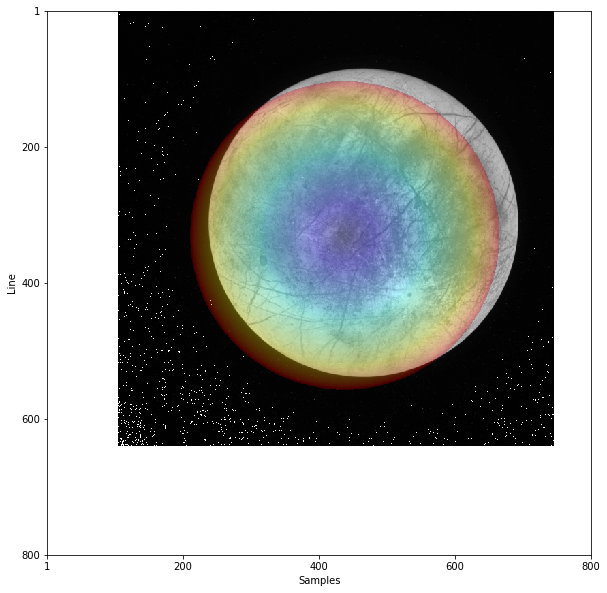

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(img.data, cmap='gray', extent=img.extent)
ax.imshow(img.emi, cmap='jet', extent=img.extent, alpha=.3)

ax.set_xlabel('Samples')
ax.set_ylabel('Line')
ax.set_xticks(img.sticks)
ax.set_yticks(img.lticks);

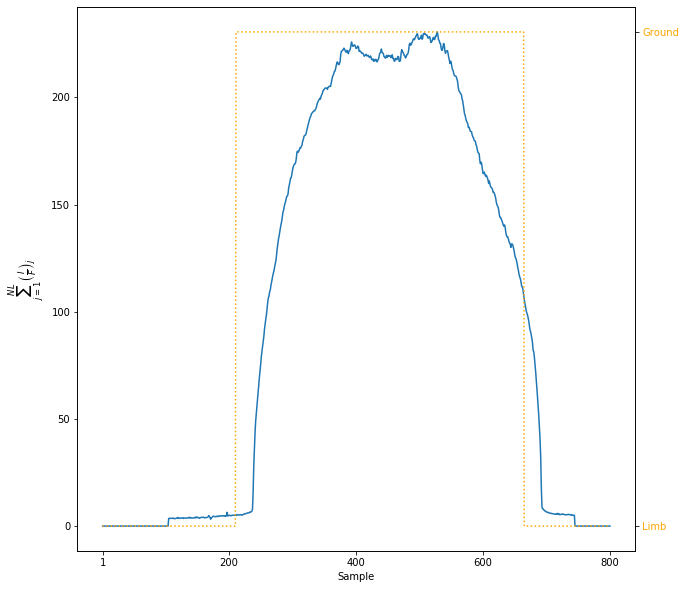

In [11]:
fig, ax0 = plt.subplots(1, 1, figsize=(10, 10))
ax1 = ax0.twinx()

ax0.plot(img.s, np.nansum(img.data, axis=0))
ax1.plot(img.s, np.nansum(img.ground, axis=0) > 0, color='orange', ls=':')

ax0.set_xticks(img.sticks)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Limb', 'Ground'], color='orange')

ax0.set_xlabel('Sample')
ax0.set_ylabel(r'$\sum_{j=1}^{NL} \left(\frac{I}{F}\right)_j$', fontsize=12);

To calculate the offset of the navigation data compare to the `I/F` data, we use a [`numpy.correlate`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html) (see `ssi.align.corr_offset`).
The function `alignement()` allow the user to search for offset in sample and line direction and store the results in the `offset` attribute.

In [12]:
img.alignment()
img.offset

(28, -19)

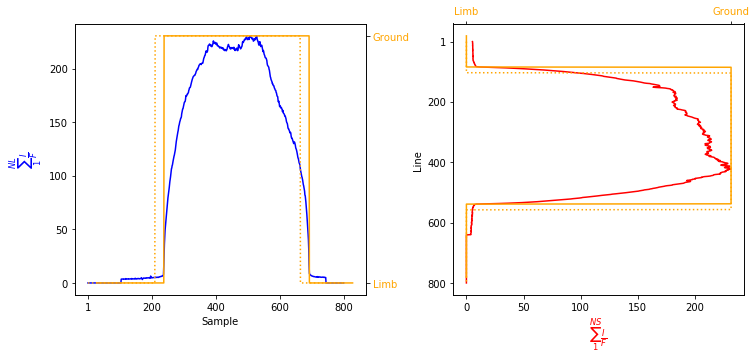

In [13]:
offset_s, offset_l = img.alignment()  # Store offset alignment values
img.alignment(False)                  # Disable alignement

fig, (ax0, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=.3)

ax1 = ax0.twinx()
ax3 = ax2.twiny()

ax0.plot(img.s, np.nansum(img.data, axis=0), 'b')
ax1.plot(img.s, np.nansum(img.ground, axis=0) > 0, color='orange', ls=':')
ax1.plot(img.s + offset_s, np.nansum(img.ground, axis=0) > 0, color='orange')

ax2.plot(np.nansum(img.data, axis=1), img.l, 'r')
ax3.plot(np.nansum(img.ground, axis=1) > 0, img.l, color='orange', ls=':')
ax3.plot(np.nansum(img.ground, axis=1) > 0, img.l + offset_l, color='orange')

ax0.set_xticks(img.sticks)
ax1.set_yticks([])
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Limb', 'Ground'], color='orange')

ax2.set_yticks(img.lticks)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Limb', 'Ground'], color='orange')
ax2.invert_yaxis()

ax0.set_xlabel('Sample')
ax0.set_ylabel(r'$\sum_{1}^{NL} \frac{I}{F}$', fontsize=12, color='blue')

ax2.set_ylabel('Line')
ax2.set_xlabel(r'$\sum_{1}^{NS} \frac{I}{F}$', fontsize=12, color='red');

If the alignement is enable, the navigation planes are automatically offset to take this change into account:

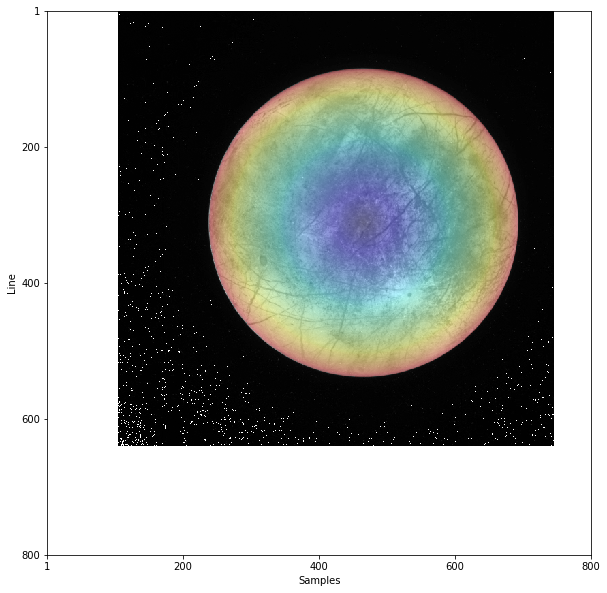

In [14]:
img.alignment(True)  # Align navigation data and I/F data

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(img.data, cmap='gray', extent=img.extent)
ax.imshow(img.emi, cmap='jet', extent=img.extent, alpha=.3)

ax.set_xlabel('Samples')
ax.set_ylabel('Line')
ax.set_xticks(img.sticks)
ax.set_yticks(img.lticks);

We can see that the pixels navigation information are also shitted accordingly to the offset:

In [15]:
img.alignment(False)
print(repr(img[400, 300]), '\n')

img.alignment(True)
print(repr(img[400, 300]))

<SSIPixel> C0360063913R_cal-S400_L300
 - Sample: 400
 - Line: 300
 - I/F: 4.37e-01
 - Lon: 303.2°W
 - Lat: 8.0°N
 - Inc: 13.7°
 - Emi: 12.3°
 - Phase: 2.1°
 - Res: 2.1 km/pix 

<SSIPixel> C0360063913R_cal-S400_L300
 - Sample: 400
 - Line: 300
 - I/F: 4.37e-01
 - Lon: 309.9°W
 - Lat: 2.6°N
 - Inc: 17.4°
 - Emi: 17.0°
 - Phase: 2.1°
 - Res: 2.1 km/pix


## Fit SSI data

In [16]:
L = 250
i_f = img.data[:, L]
inc = img.inc[:, L]
emi = img.emi[:, L]
mu0 = img.mu0[:, L]
mu1 = img.mu1[:, L]

Intensity formula as a function of the incidence and emission angles:

$$ \frac{I}{F} = B_0 \cdot \mu_0 ^ k \cdot \mu_1 ^{k - 1}$$

$$\Rightarrow \ln(\frac{I}{F} \cdot \mu_1) = k \cdot \ln(\mu_0 \cdot \mu_1) + \ln(B_0)$$

In [17]:
xdata = np.log(mu0 * mu1)
ydata = np.log(i_f * mu1)
cond = ~np.isnan(xdata) & ~np.isnan(ydata)

k, lnB0, r_value, p_value, std_err = linregress(xdata[cond], ydata[cond])

f'k: {k:.2e}, B0: {np.exp(lnB0):.2e}, r^2: {r_value**2:.2f}'

'k: 4.90e-01, B0: 4.42e-01, r^2: 0.93'

In [18]:
x = np.linspace(np.nanmin(xdata), np.nanmax(xdata))
y = k * x + lnB0

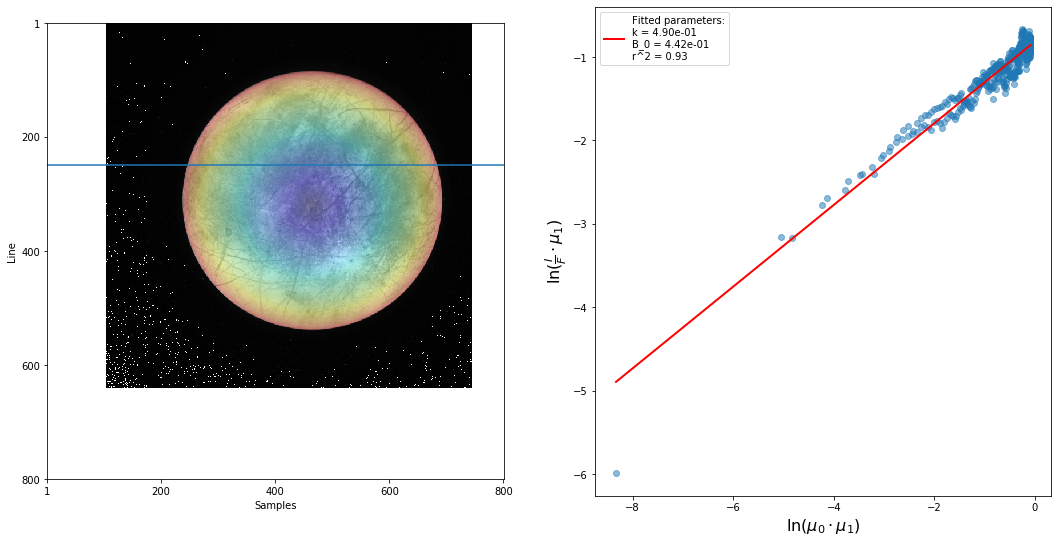

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 9))

ax0.imshow(img.data, cmap='gray', extent=img.extent)
ax0.imshow(img.inc, cmap='jet', extent=img.extent, alpha=.3)
ax0.axhline(L)

ax0.set_xlabel('Samples')
ax0.set_ylabel('Line')
ax0.set_xticks(img.sticks)
ax0.set_yticks(img.lticks)

ax1.scatter(xdata, ydata, alpha=.5)
ax1.plot(x, y, 'r-', lw=2, label=f'Fitted parameters:\nk = {k:.2e}\nB_0 = {np.exp(lnB0):.2e}\nr^2 = {r_value**2:.2f}')
ax1.set_xlabel(r'$\ln(\mu_0 \cdot \mu_1)$', fontsize=16)
ax1.set_ylabel(r'$\ln(\frac{I}{F} \cdot \mu_1)$', fontsize=16)
ax1.legend();